<a href="https://colab.research.google.com/github/ruqqyah/gtm/blob/main/gtmruqqyah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random

# Load data
data = pd.read_csv("calls_dataset_100.csv")

# Preprocessing
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize, remove stopwords, lemmatize
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
    return " ".join(tokens)

data["text_snippet"] = data["text_snippet"].apply(preprocess_text)

# Convert labels to multi-label binary format
mlb = MultiLabelBinarizer()
data["labels"] = data["labels"].apply(lambda x: x.split(", "))
# The labels should be generated after data augmentation
# labels = mlb.fit_transform(data["labels"])

# Augmentation for minority labels
def augment_text(row):
    # Add noise by shuffling words or replacing with synonyms
    words = row.split()
    random.shuffle(words)
    return " ".join(words)

minority_labels = ["Security", "Objection"]  # Example minority classes
mlb.fit(data["labels"])  # This line is added to fit the binarizer

for idx, label in enumerate(mlb.classes_):
    if label in minority_labels:
        minority_data = data[data["labels"].apply(lambda x: label in x)]
        augmented = minority_data.sample(frac=0.5).copy()
        augmented["text_snippet"] = augmented["text_snippet"].apply(augment_text)
        data = pd.concat([data, augmented])

# Generate labels after data augmentation is complete
labels = mlb.transform(data["labels"])  # Use transform instead of fit_transform

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data["text_snippet"], labels, test_size=0.2, random_state=42
)

FileNotFoundError: [Errno 2] No such file or directory: 'calls_dataset_100.csv'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a One-vs-Rest Logistic Regression
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)


                    precision    recall  f1-score   support

       Competition       0.00      0.00      0.00         7
          Features       0.00      0.00      0.00         6
         Objection       0.00      0.00      0.00         9
          Positive       0.00      0.00      0.00         2
Pricing Discussion       0.50      0.17      0.25        12
          Security       0.50      0.20      0.29         5

         micro avg       0.33      0.07      0.12        41
         macro avg       0.17      0.06      0.09        41
      weighted avg       0.21      0.07      0.11        41
       samples avg       0.12      0.12      0.12        41



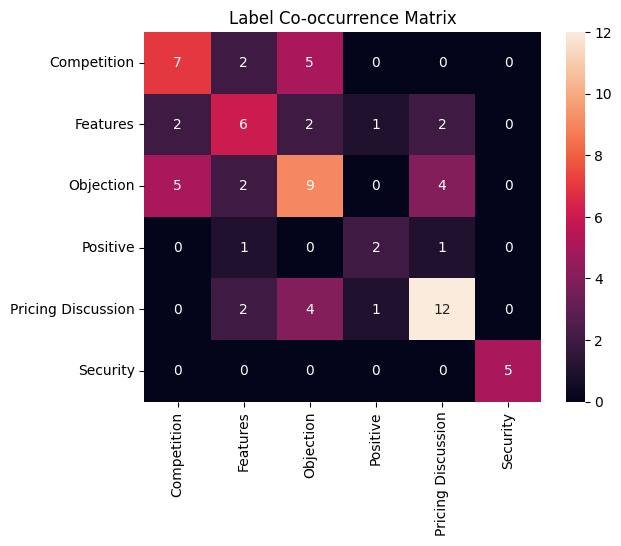

In [ ]:
# Classification report
report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0)
print(report)

# Visualize label co-occurrence
import seaborn as sns
import matplotlib.pyplot as plt

co_occurrence = (y_test.T @ y_test)
sns.heatmap(co_occurrence, annot=True, fmt="d", xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Label Co-occurrence Matrix")
plt.show()
